In [1]:
!pwd

/Users/michaelka/Developer/ml/projects/ycup21


In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

# Load data

In [25]:
if IN_COLAB:
    metadata_file = '/content/'
    images_directory = './content/images/'
else:
    metadata_file = './data/metadata.json'
    images_directory = './images/images'

In [120]:
import torch
from torch import nn

from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [50]:
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import jsonlines
import os
import json

In [82]:
def get_image_transform(randomize: bool):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    if randomize:
        return transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        return transforms.Compose([
#             transforms.Resize(256),
#             transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize
        ])

In [46]:
class I2TDataset(Dataset):
    def __init__(
        self,
        metadata_file,
        images_directory,
        tokenizer,
        read_jsonlines = True,
        start = 0,
        end = None,
        randomize = True,
        tqdm_load = False
    ):
        super().__init__()
        self.data = []
        
        if read_jsonlines:
            with jsonlines.open(metadata_file) as reader:
                if tqdm_load:
                    reader = tqdm(reader)
                for obj in reader:
                    self.data.append((obj['image'], obj['queries']))
            self.data = self.data[slice(start, end)]
        else:
            with open(metadata_file) as json_file:
                json_strings = json_file.readlines()
            for json_string in json_strings[start:end]:
                metadata = json.loads(json_string)
                self.data.append((metadata['image'], metadata['queries']))            

        self.images_directory = Path(images_directory)
        self.randomize = randomize
        self.image_transform = get_image_transform(randomize=randomize)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        img, texts = self.data[idx]
        img = Image.open((self.images_directory / f'image_{img}').with_suffix('.jpg'))
        img = img.convert('RGB')
        img = self.image_transform(img)
        if self.randomize:
            text = np.random.choice(texts)
        else:
            text = texts[0]
        return {'image': img, 'text': self.tokenizer.encode_ids(text)}

    @staticmethod
    def collate_fn(items):
        return {
            'image': default_collate([x['image'] for x in items]),
            'text': text_collate_fn([x['text'] for x in items])
        }

In [29]:
with open(metadata_file) as json_file:
    json_strings = json_file.readlines()

In [31]:
len(json_strings), json_strings[0]

(5462418,
 '{"image": 1, "queries": ["samsing a52", "samsung a32", "смартфон samsung galaxy a32 128gb awesome violet", "samsung a 52", "samsung galaxy a32 лаванда"]}\n')

In [16]:
from bpemb import BPEmb

In [17]:
embedding_size: int = 200
vocab_size: int = 200000

bpemb_ru = BPEmb(lang="ru", dim=embedding_size, vs=vocab_size)

In [22]:
images = os.listdir(images_directory)
len(images)

93

In [110]:
dataset = I2TDataset(
    metadata_file,
    images_directory,
    tokenizer = bpemb_ru,
    read_jsonlines = False,
    start = 0,
    end = 50,
    randomize = False,
    tqdm_load = True
)

In [111]:
len(dataset)

50

In [112]:
dataset_item = dataset[0]

In [113]:
dataset.data[0]

(1,
 ['samsing a52',
  'samsung a32',
  'смартфон samsung galaxy a32 128gb awesome violet',
  'samsung a 52',
  'samsung galaxy a32 лаванда'])

In [114]:
# dataset_item

In [118]:
bpemb_ru.encode('samsing a52')

['▁sam', 'sing', '▁a', '00']

In [115]:
bpemb_ru.encode_ids('samsing a52')

[13235, 33493, 449, 4]

In [116]:
dataset_item['text']

[13235, 33493, 449, 4]

In [87]:
image = dataset_item['image']
image.shape

torch.Size([3, 224, 224])

In [63]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


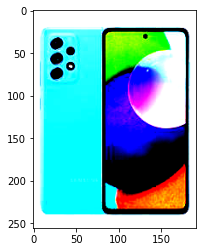

In [71]:
plt.imshow(image.permute(1,2,0))

# Dataloader

In [78]:
from torch.utils.data._utils.collate import default_collate

In [117]:
offsets = [0,3,4,2]
torch.tensor(offsets[:-1]).cumsum(dim=0)

tensor([0, 3, 7])

In [79]:
def text_collate_fn(items):
    ids = []
    offsets = [0]
    for item in items:
        ids.append(torch.tensor(item, dtype=torch.int64))
        offsets.append(len(item))
    return {
        'ids': torch.cat(ids),
        'offsets': torch.tensor(offsets[:-1]).cumsum(dim=0)
    }

In [98]:
dataloader = DataLoader(
    dataset,
    batch_size=4,
    collate_fn=dataset.collate_fn,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

In [99]:
dataloader_iter = iter(dataloader)

In [100]:
sample_batch = next(dataloader_iter)

In [101]:
image_batch = sample_batch['image']
image_batch.shape

torch.Size([4, 3, 224, 224])

In [102]:
text_batch = sample_batch['text']

In [103]:
text_batch

{'ids': tensor([ 43435,  46588,   8908,  24297,  39930,   3628,  56346,  10334,  30295,
          32669, 199942,  21922,    528,    706,   8030,  73198,  70382,   5595,
            516,    740, 101731,  10614]),
 'offsets': tensor([ 0,  3,  9, 18])}

# TextModel

In [125]:
embedding_bag = nn.EmbeddingBag.from_pretrained(
    torch.tensor(bpemb_ru.vectors),
    freeze=True,
    sparse=False,
)

In [126]:
x = embedding_bag(text_batch['ids'], text_batch['offsets'])

In [127]:
x.shape

torch.Size([4, 200])

In [128]:
embedding = nn.Embedding.from_pretrained(
    torch.tensor(bpemb_ru.vectors),
    freeze=True,
    sparse=False,
)

In [129]:
x = embedding(text_batch['ids'])

In [130]:
x.shape

torch.Size([22, 200])